# Diabetes Prediction Model Comparison
### Traditional vs Causal Machine Learning Random Forest Models

Comparing a random forest diabetes prediction model (code from https://www.kaggle.com/code/adhadse/diabetes-prediction-with-random-forest) to a causal forest DML model that estimates the CATE of BMI on diabetes risk relative to normal BMI.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Data Pre-Processing
Pima Indians Diabetes Dataset from University of California

In [36]:
# load dataset
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [38]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [39]:
# 0 values in certain columns seem like impossible values, indicating missing data
# e.g. glucose, blood pressure, skin thickness, insulin, BMI

nan_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[nan_cols] = df[nan_cols].replace(0, np.nan)

In [40]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [41]:
# replace missing values with median of each column

for col in nan_cols:
    median = df[col].median()
    df[col] = df[col].fillna(median)    

In [42]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [43]:
# assign BMI categories

BMI_conditions = [
    (df["BMI"] < 18.5),  # underweight
    (df["BMI"] >= 18.5) & (df["BMI"] < 25),  # normal
    (df["BMI"] >= 25) & (df["BMI"] < 30),  # overweight
    (df["BMI"] >= 30)  # obese
]

categories = [0, 1, 2, 3]  # corresponding category values

df["BMI_Cat"] = np.select(BMI_conditions, categories)

# Model Training
Random Forest

## Traditional ML
Random forest classifier

In [44]:
# split data into training and testing sets

X1 = df.drop("Outcome", axis = 1) # confounding variables
y1 = df["Outcome"] # target variable

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [ ]:
# random forest fitting and hyperparameter tuning

param_grid = {
    "n_estimators": [400, 500, 600],
    "max_leaf_nodes": [14, 15, 16]}
random_forest = RandomForestClassifier(n_jobs = -1)

grid_search_rf = GridSearchCV(random_forest, param_grid = param_grid, cv = 3, scoring = "recall", return_train_score = True)

grid_search_rf.fit(X1_train, y1_train)
best_params = grid_search_rf.best_params_
print(best_params)

{'max_leaf_nodes': 16, 'n_estimators': 400}


In [ ]:
# make predictions on test set

y_pred = grid_search_rf.predict(X1_test)

In [ ]:
# evaluate model performance

print(classification_report(y1_test, grid_search_rf.predict(X1_test)))
print(recall_score(y1_test, grid_search_rf.predict(X1_test)))
print(roc_auc_score(y1_test, grid_search_rf.predict_proba(X1_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        99
           1       0.69      0.69      0.69        55

    accuracy                           0.78       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.78      0.78      0.78       154

0.6909090909090909
0.8451790633608816


In [48]:
# actual vs predicted diabetes outcome

print(f"Actual vs predicted number of people with diabetes: {y1_test.sum()} : {y_pred.sum()}")


Actual vs predicted number of people with diabetes: 55 : 55


## Causal ML
Causal forest DML with continuous treatment

In [ ]:
# split data into training and testing sets
    
y2 = df["Outcome"].values # target variable
T2 = df["BMI"].values # treatment variable (modelling BMI as treatment)
confounding_vars = ["Age", "DiabetesPedigreeFunction", "Pregnancies"] # selected confounders
X2 = df[confounding_vars].values # confounding variables

X2_train, X2_test, T2_train, T2_test, y2_train, y2_test = train_test_split(X2, T2, y2, test_size = 0.2, random_state = 42)

In [ ]:
# fitting Causal Forest DML for continuous BMI treatment

causal_forest = CausalForestDML(
    model_y = RandomForestRegressor(n_estimators = best_params["n_estimators"], max_leaf_nodes = best_params["max_leaf_nodes"], random_state = 42), # outcome model
    model_t = RandomForestRegressor(n_estimators = best_params["n_estimators"], max_leaf_nodes = best_params["max_leaf_nodes"], random_state = 42), # treatment model
    discrete_treatment = False,
    cv = 3, # cross-validation folds
    n_estimators = 1000, # number of trees in the forest
    min_samples_leaf = 10, # minimum samples per leaf node
    max_depth = 10, # maximum depth of trees in the forest
    random_state = 42
)

causal_forest.fit(Y = y2_train, T = T2_train, X = X2_train)

In [ ]:
# CATE for different BMI values relative to normal BMI

normal_bmi = df[df["BMI_Cat"] == 1]["BMI"]
normal_bmi_mid = (normal_bmi.min() + normal_bmi.max()) / 2 # midpoint of normal BMI range

cate_preds = causal_forest.effect(X = X2_test, T0 = np.full_like(T2_test, normal_bmi_mid), T1 = T2_test)

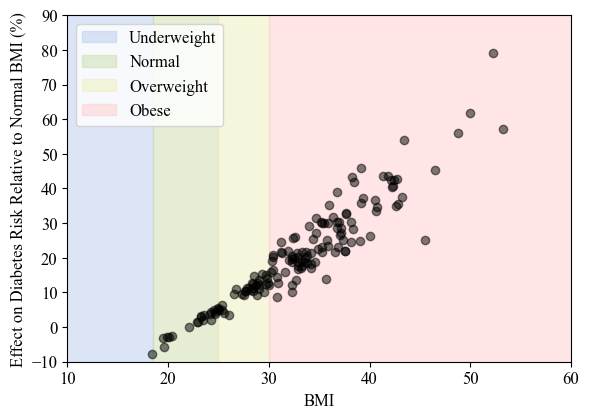

In [ ]:
# plot CATE results

plt.figure(figsize = (6.5, 4.5))
plt.xlim(10, 60)
plt.ylim(-10, 90)
plt.yticks(np.arange(-10, 91, 10))
plt.axvspan(0, 18.5, color="#BBCCEE", alpha=0.5, label="Underweight")
plt.axvspan(18.5, 25, color="#CCDDAA", alpha=0.5, label="Normal")
plt.axvspan(25, 30, color="#EEEEBB", alpha=0.5, label="Overweight")
plt.axvspan(30, 80, color="#FFCCCC", alpha=0.5, label="Obese")
plt.scatter(T2_test, cate_preds * 100, color = "black", alpha = 0.5)

plt.xlabel("BMI")
plt.ylabel("Effect on Diabetes Risk Relative to Normal BMI (%)")
plt.legend(loc = "upper left")
# plt.savefig("bmi_diabetes.png", dpi = 300)
plt.show()